**Description:**

Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates. The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default.
A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date. Following Information regarding the loan and loanee are provided:

    
Loanee Information (Demographic data like age, income, Identity proof etc.)

Loan Information (Disbursal details, amount, EMI, loan to value ratio etc.)

Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)

Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates.

**Objective:**
To find people who can be loan defaulters


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score , recall_score, fbeta_score , accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from tqdm import tqdm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
#loading data
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")
df = [df1,df2]
Type =["Train data", "Test data"]

In [4]:
print("Train data has {} datapoints and {} features.".format(df1.shape[0], df1.shape[1]))
print("Test data has {} datapoints and {} features.".format(df2.shape[0], df2.shape[1]))

Train data has 233154 datapoints and 41 features.
Test data has 112392 datapoints and 40 features.


# 1. Exploratory Data Analysis (EDA):

## 1. a] Missing Values handling:

In [5]:
for i,j in zip(df,Type):
    print("="*30,j,"="*30)
    print("-"*72)
    print(i.isnull().sum())

============================== Train data ==============================
------------------------------------------------------------------------
UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        7661
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE 

In [6]:
print("Percent of missing values in EMPLOYMENT_TYPE column of training dataset:",
      df1["EMPLOYMENT_TYPE"].isnull().sum()*100/df1.shape[0],"%")
print("Percent of missing values in EMPLOYMENT_TYPE column of testing dataset:",
      df2["EMPLOYMENT_TYPE"].isnull().sum()*100/df2.shape[0],"%")

Percent of missing values in EMPLOYMENT_TYPE column of training dataset: 3.2858110948128703 %
Percent of missing values in EMPLOYMENT_TYPE column of testing dataset: 3.0633852943269986 %


losing data is never a good idea, but since these missing values are extremely small part of dataset, we will drop those rows.

In [7]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)

## 1. b] Treatment of  categorical variables:

In [8]:
df1_cat = df1.select_dtypes(include = "object")

In [9]:
df1_cat.columns    #list of categorical columns in datasets

Index(['DATE_OF_BIRTH', 'EMPLOYMENT_TYPE', 'DISBURSAL_DATE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'AVERAGE_ACCT_AGE',
       'CREDIT_HISTORY_LENGTH'],
      dtype='object')

### 1. b] a] Converting datetime columns into age:

In [10]:
for i in df:
    i["DATE_OF_BIRTH"] = pd.to_datetime(i["DATE_OF_BIRTH"])   #converting into datetime column
    i["Age"] = 2019- i["DATE_OF_BIRTH"].dt.year
    i.drop(columns = "DATE_OF_BIRTH", inplace=True)
    i["DISBURSAL_DATE"] = pd.to_datetime(i["DISBURSAL_DATE"])
    i["Loan_age_months"] = 12 - i["DISBURSAL_DATE"].dt.month
    i.drop(columns = "DISBURSAL_DATE", inplace=True)

### 1. b] b] PERFORM_CNS_SCORE_DESCRIPTION column:

In [11]:
for i,j in zip(df,Type):
    print("="*30,"Value counts of ",j,"="*30)
    print("-"*90)
    print(i["PERFORM_CNS_SCORE_DESCRIPTION"].value_counts())
    print("")
    print("Number of unique values in",j, "=" ,len(i["PERFORM_CNS_SCORE_DESCRIPTION"].value_counts()))
    print("")
    print("")

============================== Value counts of  Train data ==============================
------------------------------------------------------------------------------------------
No Bureau History Available                                111773
C-Very Low Risk                                             15715
A-Very Low Risk                                             13790
D-Very Low Risk                                             11134
B-Very Low Risk                                              9032
M-Very High Risk                                             8632
F-Low Risk                                                   8309
K-High Risk                                                  8107
H-Medium Risk                                                6695
E-Low Risk                                                   5695
I-Medium Risk                                                5440
G-Low Risk                                                   3902
Not Scored: Sufficient Hist

**"Not Scored: More than 50 active Accounts found"** : This category is missing in test dataset.
since it is present in only 3 datapoints in training dataset, we will drop it.

In [12]:
df1 = df1[df1["PERFORM_CNS_SCORE_DESCRIPTION"] != "Not Scored: More than 50 active Accounts found"]

### 1. b] c] Columns "AVERAGE_ACCT_AGE" and "CREDIT_HISTORY_LENGTH":

In [13]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
def converter(x):
    l = x.split()
    P = int((l[0][:-3]))*12 + int(l[1][:-3])
    return P
df1["AVERAGE_ACCT_AGE"] = df1["AVERAGE_ACCT_AGE"].apply(lambda x: converter(x))
df1["CREDIT_HISTORY_LENGTH"] = df1["CREDIT_HISTORY_LENGTH"].apply(lambda x: converter(x))
df2["AVERAGE_ACCT_AGE"] = df2["AVERAGE_ACCT_AGE"].apply(lambda x: converter(x))
df2["CREDIT_HISTORY_LENGTH"] = df2["CREDIT_HISTORY_LENGTH"].apply(lambda x: converter(x))

# 2. Visualization and insights

## 2] a] Univariate analysis:

### 2. a] a] Comparison of defaults and non-defaults

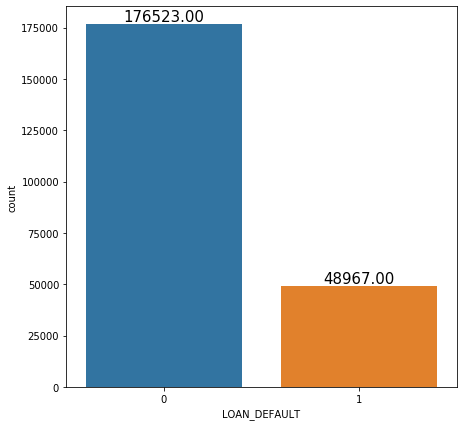

In [14]:
plt.figure(figsize=(7,7))
plot = sns.countplot(x= "LOAN_DEFAULT",data=df1)
for bar in plot.patches:
    plot.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

In [15]:
print("Percentage of people who default: ", df1["LOAN_DEFAULT"].value_counts()[1]*100/df1.shape[0])

Percentage of people who default:  21.715818883320768


### 2. a] b] Distribution of DISBURSED_AMOUNT

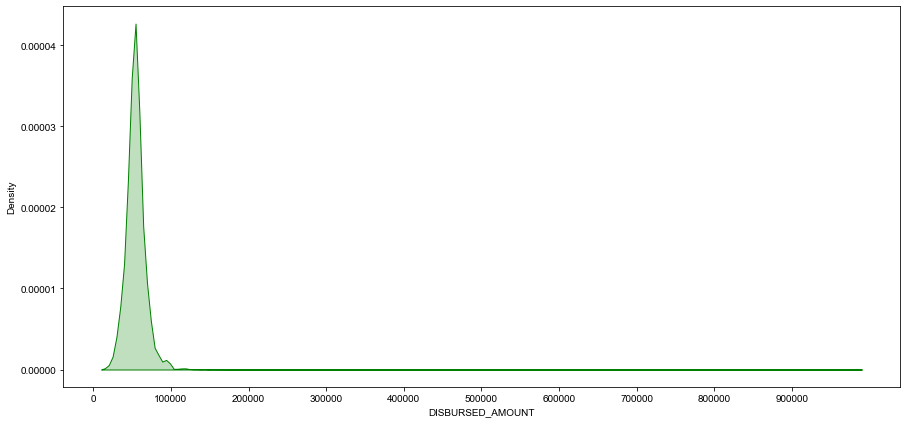

In [16]:
plt.figure(figsize=(15,7))
sns.kdeplot(x="DISBURSED_AMOUNT", data=df1, color="green", fill=True)
sns.set_style(style="darkgrid")
plt.xticks(np.arange(0,1000000,100000))
plt.show()

### 2. a] c] Distribution of ASSET_COST

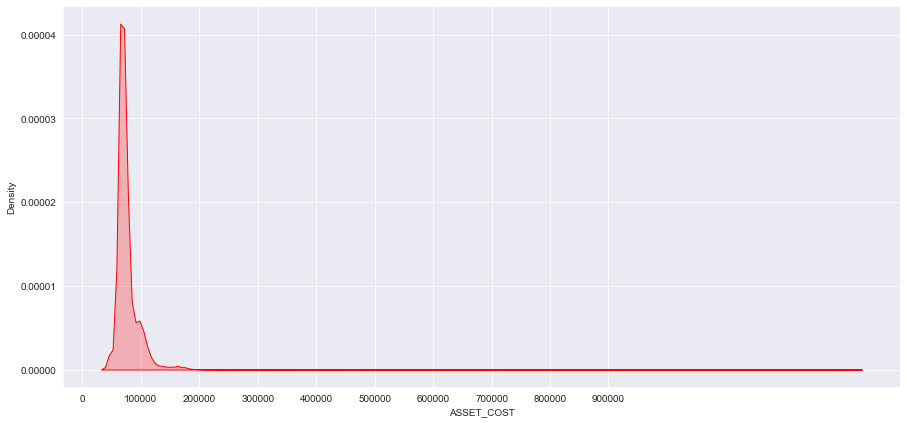

In [17]:
plt.figure(figsize=(15,7))
sns.kdeplot(x="ASSET_COST", data=df1, color="red", fill=True)
sns.set_style(style="darkgrid")
plt.xticks(np.arange(0,1000000,100000))
plt.show()

### 2. a] d] Distribution of LTV

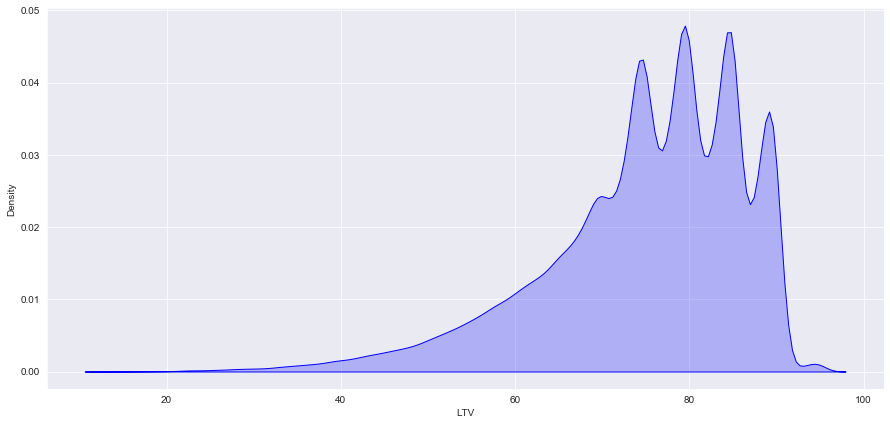

In [18]:
plt.figure(figsize=(15,7))
sns.kdeplot(x="LTV", data=df1, color="blue", fill=True)

# 3. Preprocessing 

## 3. a] Dropping unncessary columns:

In [19]:
df1.columns   # getting list of columns

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID',
       'EMPLOYMENT_TYPE', 'STATE_ID', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG',
       'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG',
       'PASSPORT_FLAG', 'PERFORM_CNS_SCORE', 'PERFORM_CNS_SCORE_DESCRIPTION',
       'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
       'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT',
       'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS',
       'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT',
       'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE',
       'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES', 'LOAN_DEFAULT', 'Age',
       'Loan_age_months'],
      dtype='object')

In [20]:
df1.drop(columns = ["UNIQUEID", "BRANCH_ID","EMPLOYEE_CODE_ID","SUPPLIER_ID",
                      "MANUFACTURER_ID","CURRENT_PINCODE_ID","STATE_ID"], inplace=True)
df2.drop(columns = ["UNIQUEID", "BRANCH_ID","EMPLOYEE_CODE_ID","SUPPLIER_ID",
                      "MANUFACTURER_ID","CURRENT_PINCODE_ID","STATE_ID"], inplace=True)

In [21]:
df1.drop(columns=["MOBILENO_AVL_FLAG","AADHAR_FLAG","PAN_FLAG","VOTERID_FLAG","DRIVING_FLAG","PASSPORT_FLAG"], inplace=True)
df2.drop(columns=["MOBILENO_AVL_FLAG","AADHAR_FLAG","PAN_FLAG","VOTERID_FLAG","DRIVING_FLAG","PASSPORT_FLAG"], inplace=True)

## 2. c] One-hot encoding

In [22]:
df1_num= df1.select_dtypes(exclude = "object").columns
df2_num =df2.select_dtypes(exclude = "object").columns            #list of all numerical columns

In [23]:
for i in (df1.select_dtypes(include = "object")).columns:
    df_dummies1 = pd.get_dummies(df1[i], drop_first=True, prefix = i)
    df1= pd.concat([df1,df_dummies1], axis=1)
    df_dummies2 = pd.get_dummies(df2[i], drop_first=True, prefix = i)
    df2= pd.concat([df2,df_dummies2], axis=1)
    #dropping initial columns
    df1.drop(columns = i, inplace=True)
    df2.drop(columns = i, inplace=True)

## 2. a] Checking class balance

In [24]:
print("="*20,"Target Class balance in Training data in % ","="*20)
print("-"*80)
print(df1["LOAN_DEFAULT"].value_counts()*100/df1.shape[0])

==================== Target Class balance in Training data in %  ====================
--------------------------------------------------------------------------------
0    78.284181
1    21.715819
Name: LOAN_DEFAULT, dtype: float64


There is a class imbalance in the data.

## 2. b] Oversampling

In [25]:
#oversampling
X = df1.drop(columns = "LOAN_DEFAULT")
Y = df1["LOAN_DEFAULT"]
sm = SMOTE(random_state=42)
x_train,y_train = sm.fit_resample(X,Y)
x_test = df2

In [26]:
y_train.value_counts()      #mbalance has been taken care of.

1    176523
0    176523
Name: LOAN_DEFAULT, dtype: int64

## 2. c] Train-test split

In [27]:
x_train , x_cv , y_train, y_cv = train_test_split(x_train,y_train, test_size = 0.3, random_state = 24 )
x_train , x_test , y_train, y_test = train_test_split(x_train,y_train, test_size = 0.3, random_state = 24 )

## 2. d] Standardization

In [28]:
#Standardizing
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_cv = sc.fit_transform(x_cv)
x_test = sc.transform(x_test)

# MODELLING

## 1. Logistic Regression

### 1. a] Gridsearch

In [29]:
warnings.simplefilter(action="ignore", category=UserWarning)
params = {"penalty":["l1","l2"], "C":[0.001,0.01,0.1]}
gs = GridSearchCV(LogisticRegression(max_iter=300),params, cv = 4, n_jobs=-1)
gs.fit(x_train,y_train)
gs.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [30]:
#initiating best parameters
LR = LogisticRegression(C= 0.1, penalty= 'l2')
LR.fit(x_train,y_train)
y_train_pred = LR.predict(x_train)
print("Traning score: ", fbeta_score(y_train,y_train_pred,beta=1))
scores = cross_val_score(LR , x_train, y_train, cv = 4, scoring = "f1")
print("Cross validation score: ", scores.mean())

Traning score:  0.6891069710900111
Cross validation score:  0.6894689191767631


### 1. b] ROC curve for logistic regression

In [31]:
#function for roc curve
def roc_(model,x_train,y_train):
    model.fit(x_train, y_train)
    y_train_proba = model.predict_proba(x_train)
    fpr,tpr,thresholds = roc_curve(y_train,[i[1] for i in y_train_proba])
    roc_df = pd.DataFrame({"fpr":fpr, "tpr":tpr, "thresholds":thresholds})
    roc_filtered = pd.DataFrame()
    for i in np.arange(1, roc_df.shape[0]-1, int(roc_df.shape[0]/10)):
        roc_filtered = pd.concat([roc_filtered,pd.DataFrame(roc_df.iloc[i,:]).T], axis=0)
    plt.figure(figsize=(10,10))
    sns.lineplot(x=roc_filtered["fpr"],y=roc_filtered["tpr"])
    sns.set_style(style="darkgrid")
    plt.yticks(np.arange(0,1,0.05))
    plt.xticks(np.arange(0,1,0.05))
    plt.xlim(0,1)
    plt.ylim(-0.05,1.05)
    plt.show()

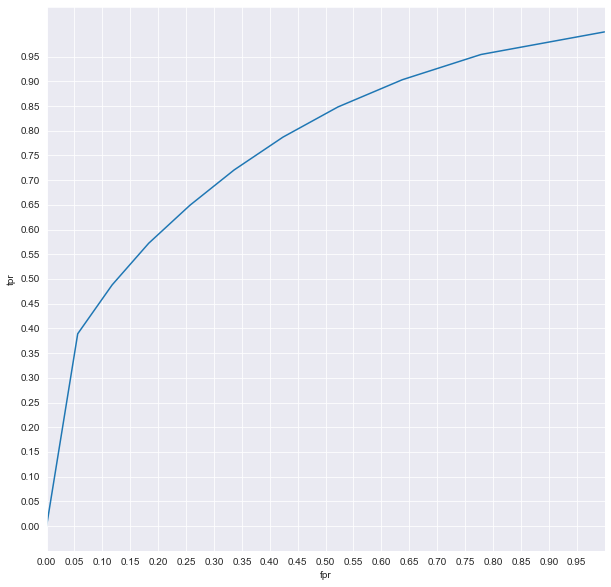

In [32]:
roc_(LogisticRegression(C= 0.1, penalty= 'l2'),x_train,y_train)

In [33]:
#buiding scores dataframe
def scoresdf(model, x_train, y_train, x_test, y_test):
    threshold_list = np.arange(0.05,1,0.05)
    scores = pd.DataFrame(np.random.randint(0,100,size=(len(threshold_list),7)),
                                                 columns = ["Thresholds","Training precision", 
                                                            "Training F1 score", 
                                                            "Training Recall",
                                                           "Testing precision", 
                                                            "Testing F1 score", 
                                                            "Testing Recall"])
    model.fit(x_train,y_train)
    y_train_proba = model.predict_proba(x_train)
    y_test_proba = model.predict_proba(x_test)
    for j,k in zip(threshold_list, np.arange(0,len(threshold_list))):
        roc_probs = []
        for i in y_train_proba:
            if i[1]<j:
                roc_probs.append(0)
            else:
                roc_probs.append(1)
        scores.loc[k,"Training precision"]=precision_score(y_train,roc_probs)
        scores.loc[k,"Training F1 score"]=fbeta_score(y_train,roc_probs,beta=1)
        scores.loc[k,"Training Recall"]=recall_score(y_train,roc_probs)
        roc_probs_test = []
        for i in y_test_proba:
            if i[1]<j:
                roc_probs_test.append(0)
            else:
                roc_probs_test.append(1)
        scores.loc[k,"Testing precision"]=precision_score(y_test,roc_probs_test)
        scores.loc[k,"Testing F1 score"]=fbeta_score(y_test,roc_probs_test,beta=1)
        scores.loc[k,"Testing Recall"]=recall_score(y_test,roc_probs_test)
    scores["Thresholds"]=threshold_list
    print("")
    print("*"*35,"SCORES","*"*35)
    print("")
    return scores

In [34]:
scoresdf(LogisticRegression(C= 0.1, penalty= 'l2'), x_train, y_train, x_cv, y_cv)


*********************************** SCORES ***********************************



,Thresholds,Training precision,Training F1 score,Training Recall,Testing precision,Testing F1 score,Testing Recall
0,0.05,0.500959,0.667464,0.999757,0.501689,0.668087,0.999642
1,0.10,0.507286,0.672279,0.996336,0.508828,0.673353,0.995116
2,0.15,0.520547,0.681323,0.985795,0.523133,0.682913,0.983216
3,0.20,0.540458,0.693270,0.966561,0.542389,0.694101,0.963641
4,0.25,0.562385,0.703536,0.939284,0.562650,0.702531,0.934977
5,0.30,0.584215,0.710535,0.906550,0.582950,0.708570,0.903200
6,0.35,0.606304,0.714575,0.869922,0.603297,0.711638,0.867407
7,0.40,0.631114,0.715598,0.826196,0.626185,0.712750,0.827088
8,0.45,0.662075,0.709131,0.763388,0.655118,0.707411,0.768778
9,0.50,0.703967,0.689107,0.674862,0.695878,0.690602,0.685406


## 2. Decision Tree Classifier

### 2. a] Checking for various depths

In [35]:
training_scores=[]
cv_scores=[]
depth=[]
for i in tqdm(np.arange(6,18,3)):
    DT = DecisionTreeClassifier(max_depth=i)
    DT.fit(x_train,y_train)
    y_train_pred = DT.predict(x_train)
    training_scores.append(fbeta_score(y_train,y_train_pred,beta=1))
    scores = cross_val_score(DT , x_train, y_train, cv = 4, scoring = "f1")
    cv_scores.append(scores.mean())
    depth.append(i)

100%|██████████| 4/4 [00:24<00:00,  6.04s/it]


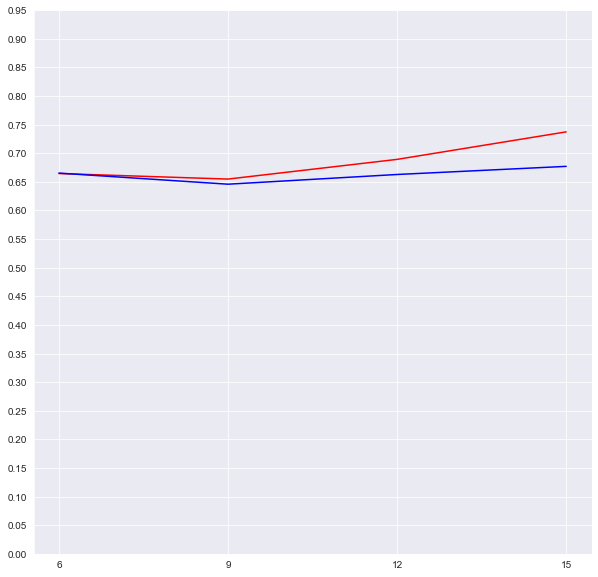

In [36]:
plt.figure(figsize=(10,10))
sns.lineplot(x=depth,y=training_scores,color="r")
sns.lineplot(x=depth,y=cv_scores,color="b")
sns.set_style(style="whitegrid")
plt.yticks(np.arange(0,1,0.05))
plt.xticks(np.arange(6,18,3))
plt.show()

In [37]:
DT_results = pd.DataFrame({"Depth":depth,"Training scores": training_scores,"Cross val scores":cv_scores})
DT_results

,Depth,Training scores,Cross val scores
0,6,0.664545,0.665327
1,9,0.654883,0.645914
2,12,0.689293,0.662891
3,15,0.737365,0.677092


12 is the best depth, after that model starts overfitting rapidly.

### 2. b] ROC curve for decision tree:

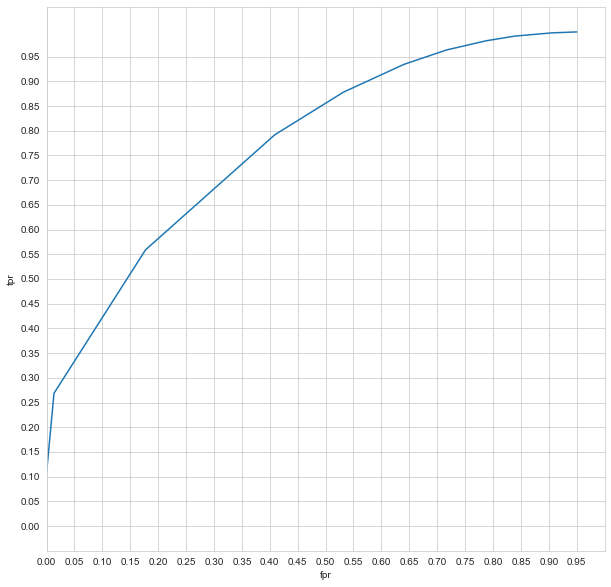

In [38]:
roc_(DecisionTreeClassifier(max_depth=12),x_train,y_train)

### 2. c] Results for decision tree

In [39]:
scoresdf(DecisionTreeClassifier(max_depth=12), x_train, y_train, x_cv, y_cv)


*********************************** SCORES ***********************************



,Thresholds,Training precision,Training F1 score,Training Recall,Testing precision,Testing F1 score,Testing Recall
0,0.05,0.520256,0.684223,0.999110,0.515463,0.676496,0.983857
1,0.10,0.535980,0.696496,0.994255,0.527044,0.683866,0.973542
2,0.15,0.545962,0.703514,0.988881,0.534033,0.687187,0.963509
3,0.20,0.561041,0.712618,0.976421,0.546658,0.692284,0.943670
4,0.25,0.576692,0.720435,0.959626,0.559167,0.696460,0.923115
5,0.30,0.592095,0.725512,0.936544,0.571858,0.698402,0.896864
6,0.35,0.612925,0.728404,0.897500,0.585304,0.697718,0.863579
7,0.40,0.633181,0.727638,0.855219,0.599217,0.696476,0.831426
8,0.45,0.659509,0.719705,0.791995,0.621857,0.689346,0.773266
9,0.50,0.704602,0.689610,0.675243,0.653416,0.660793,0.668339


## 3. Random Forest Classifier 

### 3. a] Checking for various depths:

In [40]:
training_scores=[]
cv_scores=[]
depth=[]
for i in tqdm(np.arange(6,18,3)):
    RF = RandomForestClassifier(max_depth=i, n_estimators=300)
    RF.fit(x_train,y_train)
    y_train_pred = RF.predict(x_train)
    training_scores.append(fbeta_score(y_train,y_train_pred,beta=1))
    scores = cross_val_score(RF , x_train, y_train, cv = 4, scoring = "f1")
    cv_scores.append(scores.mean())
    depth.append(i)

100%|██████████| 4/4 [13:46<00:00, 206.52s/it]


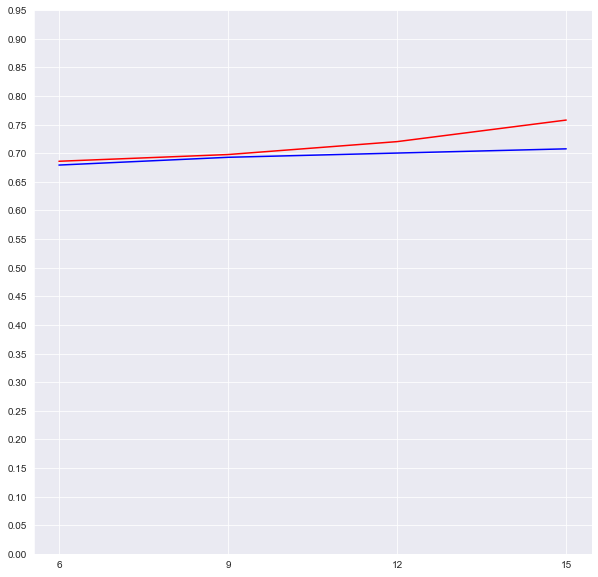

In [41]:
plt.figure(figsize=(10,10))
sns.lineplot(x=depth,y=training_scores,color="r")
sns.lineplot(x=depth,y=cv_scores,color="b")
sns.set_style(style="whitegrid")
plt.yticks(np.arange(0,1,0.05))
plt.xticks(np.arange(6,18,3))
plt.show()

In [42]:
RF_results = pd.DataFrame({"Depth":depth,"Training scores": training_scores,"Cross val scores":cv_scores})
RF_results

,Depth,Training scores,Cross val scores
0,6,0.686001,0.679346
1,9,0.697748,0.692925
2,12,0.720330,0.700344
3,15,0.758007,0.707714


from chart, best depth looks to be 12. after that, model starts overfitting rapidly.

### 3. b] ROC curve for Random Forest (depth=12)

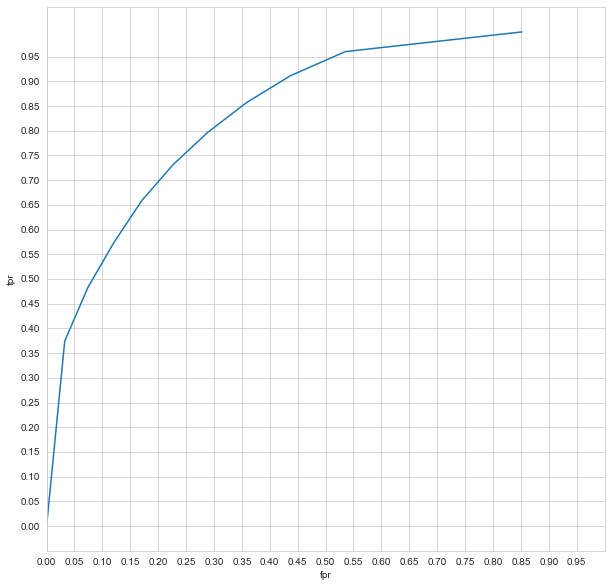

In [43]:
roc_(RandomForestClassifier(max_depth=i, n_estimators=300), x_train,y_train)

### 3. c] Results for random forest classifier

In [44]:
scoresdf(RandomForestClassifier(max_depth=i, n_estimators=300), x_train, y_train, x_cv, y_cv)


*********************************** SCORES ***********************************



,Thresholds,Training precision,Training F1 score,Training Recall,Testing precision,Testing F1 score,Testing Recall
0,0.05,0.501653,0.668134,1.000000,0.500841,0.667405,0.999962
1,0.10,0.509160,0.674760,1.000000,0.503578,0.669700,0.999378
2,0.15,0.521992,0.685932,1.000000,0.509174,0.674196,0.997473
3,0.20,0.539004,0.700455,0.999988,0.516998,0.680080,0.993456
4,0.25,0.560659,0.718340,0.999422,0.528639,0.688094,0.985291
5,0.30,0.587464,0.738871,0.995423,0.544457,0.697237,0.969204
6,0.35,0.618161,0.758834,0.982397,0.563648,0.706170,0.945160
7,0.40,0.655014,0.773560,0.944496,0.587013,0.713985,0.911045
8,0.45,0.693153,0.777333,0.884786,0.614473,0.718158,0.863937
9,0.50,0.745815,0.757887,0.770357,0.649324,0.715406,0.796462


### 3. d] feature importance using RF:

In [45]:
feature_imp = pd.DataFrame(RF.feature_importances_)
features_list = list(df1.columns)
features_list.remove("LOAN_DEFAULT")
feature_imp["Column_name"] = features_list
feature_imp.rename(columns={0:"importance in percent"}, inplace=True)
feature_imp["importance in percent"] = feature_imp["importance in percent"]*100
feature_imp.sort_values(by="importance in percent", ascending=False, inplace=True)
feature_imp.reset_index(inplace=True)
feature_imp.rename(columns={"index":"column number"}, inplace=True)
feature_imp

,column number,importance in percent,Column_name
0,3,14.072604,PERFORM_CNS_SCORE
1,2,7.139076,LTV
2,0,5.929280,DISBURSED_AMOUNT
3,25,5.242528,EMPLOYMENT_TYPE_Self employed
4,23,4.487232,Age
5,16,4.389033,PRIMARY_INSTAL_AMT
6,24,4.337853,Loan_age_months
7,28,4.016595,PERFORM_CNS_SCORE_DESCRIPTION_D-Very Low Risk
8,1,3.796918,ASSET_COST
9,30,3.249116,PERFORM_CNS_SCORE_DESCRIPTION_F-Low Risk


## 4. XGBOOST 

### 4. a] Checking at various depths

In [46]:
#xgbclassifier
depth = [4,5,6,7,8,9]
cv_scores=[]
training_scores=[]
for i in tqdm(depth):
    xg = xgb.XGBClassifier(max_depth=i, use_label_encoder=False, eval_metric= "logloss")
    xg.fit(x_train,y_train)
    y_pred_train = xg.predict(x_train)
    training_scores.append(fbeta_score(y_train,y_pred_train, beta=1))
    scores = cross_val_score(xg , x_train, y_train , cv = 4, scoring = "f1")
    cv_scores.append(scores.mean())

100%|██████████| 6/6 [02:59<00:00, 29.89s/it]


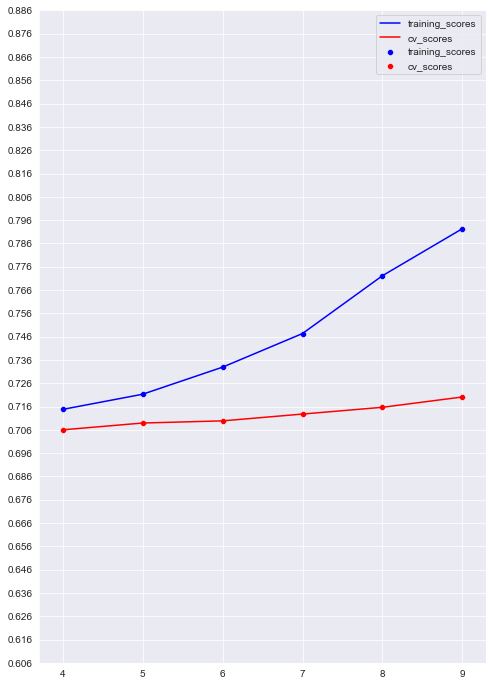

In [47]:
plt.figure(figsize=(8,12))
sns.lineplot(x=depth, y=training_scores, color = "b",label = "training_scores")
sns.lineplot(x=depth, y=cv_scores, color = "r",label = "cv_scores")
sns.scatterplot(x=depth, y=training_scores, color = "b",label = "training_scores")
sns.scatterplot(x=depth, y=cv_scores, color = "r",label = "cv_scores")
sns.set_style()
plt.legend()
plt.yticks(np.arange(min(cv_scores)-0.1,max(training_scores)+0.1,0.01))
plt.show()

In [48]:
xgboost_results = pd.DataFrame({"Depth":depth,"Training scores": training_scores,"Cross val scores":cv_scores})
xgboost_results

,Depth,Training scores,Cross val scores
0,4,0.714784,0.706018
1,5,0.721291,0.708937
2,6,0.732920,0.709861
3,7,0.747353,0.712785
4,8,0.772185,0.715692
5,9,0.792373,0.720121


Model starts overfitting drastically after depth 6. this is best case for xgboostclassifier.

### 4. b] ROC curve for XGBoost (depth = 6)

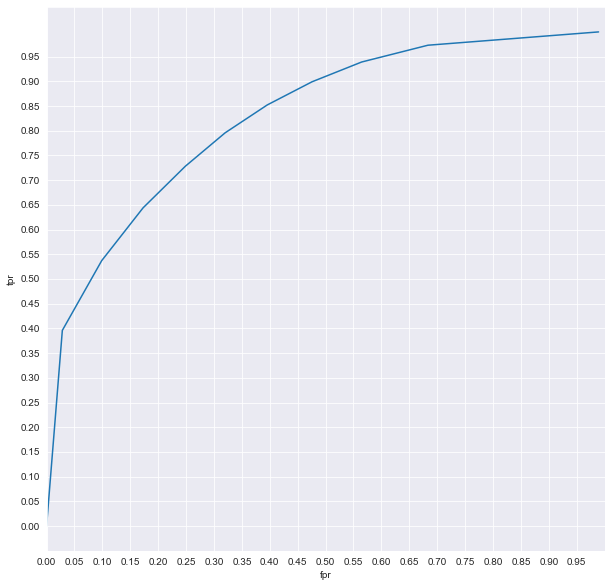

In [49]:
roc_(xgb.XGBClassifier(max_depth=6, use_label_encoder=False, eval_metric= "logloss"), x_train,y_train)

### 4. c] Results for xgboost: 

In [50]:
scoresdf(xgb.XGBClassifier(max_depth=6, use_label_encoder=False, eval_metric= "logloss"), x_train, y_train, x_cv, y_cv)


*********************************** SCORES ***********************************



,Thresholds,Training precision,Training F1 score,Training Recall,Testing precision,Testing F1 score,Testing Recall
0,0.05,0.506434,0.672333,0.999873,0.511786,0.675808,0.994550
1,0.10,0.523861,0.687082,0.998047,0.530259,0.687641,0.977879
2,0.15,0.547423,0.705569,0.992210,0.546186,0.695796,0.958285
3,0.20,0.572773,0.723507,0.981911,0.558627,0.700927,0.940502
4,0.25,0.597883,0.738500,0.965602,0.568712,0.704534,0.925585
5,0.30,0.624112,0.750081,0.939758,0.576908,0.706980,0.912780
6,0.35,0.650812,0.756952,0.904458,0.583989,0.708422,0.900240
7,0.40,0.680566,0.758447,0.856456,0.589751,0.708815,0.888114
8,0.45,0.713926,0.751912,0.794168,0.596728,0.709992,0.876327
9,0.50,0.753541,0.732920,0.713397,0.605702,0.711516,0.862127


# 5. Summarizing the results and conclusion

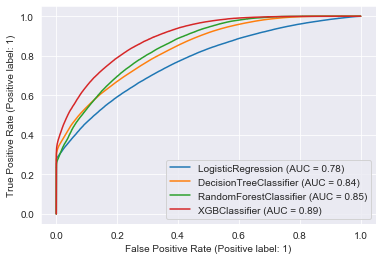

In [51]:
disp =plot_roc_curve(LR, x_train,y_train)
plot_roc_curve(DT, x_train,y_train, ax=disp.ax_)
plot_roc_curve(RF, x_train,y_train, ax=disp.ax_)
plot_roc_curve(xg, x_train,y_train, ax=disp.ax_)

**We were given a vehicle loan dataset with objective of finding the people who may default.**

given dataset consists of:

1. Training data with 233154 datapoints and 41 features.

2. Testing data with 112392 datapoints and 40 features.


-First, we started with basic data cleaning operations like missing values handling and converting required columns into appropriate format. 
-Second step was trying to extract information from data using fundamental libraries such as pandas, numpy as matplotlib.  

-Since this was a case of imbalanced data, oversampling using SMOTE has been done.

-data was split into 3 parts, training, cross validation and testing. 30% data was taken for cross validation and 30% of remaining data was taken for testing purpose.

-Data was standardized and then taken for modelling.


**Metrics used for measurement of performance:**

1. Precision

2. F1 score

3. Recall


**4 machine learning algorithms were applied on data:**

1. Logistic regression. 

2. Decision tree

3. Random forest

4. Extreme boost



1. Logistic regression: Best hyperparameters were found using gridsearch and then checked for all the metrics across various thresholds.

2. Decision tree, random forest and xgboost: checked for various depths, best depth was found and then checked for across all thresholds for all metrics.



Best model can be chosen according to requirement.

**Since objective of this study is to find the vehical loan defaulter, clearly recall is more important than precision so we can give slight edge to recall but again, you can not have 'bad' precision because then you will be classifying a lot more people as defaulters than required. so a proper balance needs to be found and it can be found checking all scores dataframes across all models.**